This Python code translates the R code (the example_acm.R) into an equivalent plot using ChatGPT. The code creates a scatter plot that displays an adaptive comfort model based on the ASHRAE Global Thermal Comfort Database II. The plot shows the relationship between outdoor temperature and neutral temperature for different building cooling types: Air Conditioned, Mixed Mode, and Naturally Ventilated. </br>

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [7]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)


In [8]:
# Data preparation
df_acm2 = df_measurements.loc[(~df_measurements['ta'].isna()) &
                              (~df_measurements['thermal_sensation'].isna()) &
                              (~df_measurements['rh'].isna()) &
                              (~(df_measurements['t_out_isd'].isna()) | ~(df_measurements['t_out'].isna()))]

# Fill the missing values in the outdoor temperature column 
df_acm2.loc[:, 't_out_combined'] = df_acm2.loc[:, 't_out_isd'].fillna(df_acm2.loc[:, 't_out'])

# Remove original temperature columns
df_acm2 = df_acm2.drop(columns=['t_out_isd', 't_out'])

# Merge metadata and databased by office buildings
df_acm2 = df_acm2.merge(df_meta[['building_id', 'region', 'building_type', 'cooling_type', 'records']], on='building_id', how='left')
df_acm2 = df_acm2[df_acm2['building_type'] == 'office']
df_acm2 = df_acm2.drop(columns=['building_type'])

In [13]:
df_acm2

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,set,pmv,ppd,pmv_ce,ppd_ce,t_mot_isd,t_out_combined,region,cooling_type,records
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,28.1,0.50,10.2,0.38,8.0,17.4,16.295833,oceania,mixed mode,170
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,27.2,0.40,8.4,0.40,8.4,17.4,16.295833,oceania,mixed mode,170
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,24.8,-0.07,5.1,-0.07,5.1,17.4,16.295833,oceania,mixed mode,170
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,25.5,0.31,7.0,0.14,5.4,17.4,16.295833,oceania,mixed mode,170
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,26.0,0.05,5.0,-0.06,5.1,17.4,16.295833,oceania,mixed mode,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71532,105532,105533,786,2011-01-21T00:00:00Z,winter,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-20.3,-19.854167,asia,NaN,83
71533,105533,105534,786,2011-01-21T00:00:00Z,winter,NaN,26.0,male,1.80,75.0,...,NaN,NaN,NaN,NaN,NaN,-20.3,-19.854167,asia,NaN,83
71534,105534,105535,786,2011-01-21T00:00:00Z,winter,NaN,33.0,female,1.60,55.0,...,NaN,NaN,NaN,NaN,NaN,-20.3,-19.854167,asia,NaN,83
71535,105535,105536,786,2011-01-21T00:00:00Z,winter,NaN,23.0,male,1.76,65.0,...,NaN,NaN,NaN,NaN,NaN,-20.3,-19.854167,asia,NaN,83


In [12]:
# Adaptive comfort analysis
def run_lm(group):
    try:
        lm_result = smf.ols(formula='ta ~ thermal_sensation', data=group).fit()
        if lm_result.pvalues['Intercept'] < 0.05:
            return lm_result.params['Intercept']
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

df_models = df_acm2.groupby('building_id').apply(run_lm).reset_index()
print(df_models)
df_models.columns = ['building_id', 'neutral_temp']

df_models = df_models.merge(df_meta[['building_id', 'records', 'cooling_type', 'region']], on='building_id', how='left')
df_models['t_out_mean'] = df_acm2.groupby('building_id')['t_out_combined'].mean().values


     building_id          0
0              1  22.585738
1              2  22.058339
2              3  23.142187
3              4  23.642083
4              5  22.071788
..           ...        ...
299          763  20.837842
300          771  23.439683
301          772  23.082808
302          779  28.210619
303          786  24.368883

[304 rows x 2 columns]


NameError: name 'FormatStrFormatter' is not defined

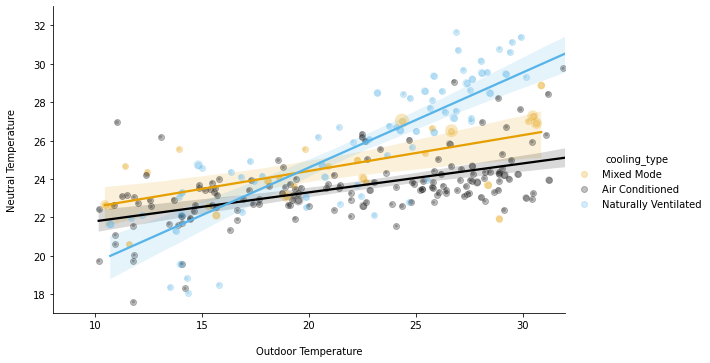

In [10]:
# Visualization
# Assuming df_models is already loaded
filtered_df = df_models[(df_models['t_out_mean'] >= 10) & (df_models['t_out_mean'] <= 33) &
                        (df_models['neutral_temp'] > 17) & (df_models['neutral_temp'] < 32)].copy()

filtered_df['cooling_type'] = filtered_df['cooling_type'].str.title()
filtered_df['point_size'] = filtered_df['records']

colors = {"Air Conditioned": "#000000", "Mixed Mode": "#E69F00", "Naturally Ventilated": "#56B4E9"}

lm = sns.lmplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                palette=colors, scatter_kws={'alpha': 0.25}, 
                height=5, aspect=1.6)

# Add point_size directly to the scatterplot
sns.scatterplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                size='point_size', sizes=(10, 200), legend=False, 
                palette=colors, alpha=0.25, ax=lm.ax)

lm.ax.set_xlim(8, 32)
lm.ax.set_ylim(17, 33)
lm.ax.set_xlabel('\nOutdoor Temperature')
lm.ax.set_ylabel('Neutral Temperature\n')
lm.ax.xaxis.set_major_formatter(FormatStrFormatter('%d°C'))
lm.ax.yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

# Annotations
lm.ax.annotate("Lower 80%", xy=(33.7, 24.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Lower 90%", xy=(33.7, 25.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 90%", xy=(33.7, 28.0), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 80%", xy=(33.7, 30.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')


plt.title('Adaptive Comfort Model', fontsize=16)
plt.suptitle('Example analysis of adaptive thermal comfort using the ASHRAE Global Thermal Comfort Database II', fontsize=12, fontstyle='italic', y=0.95)
plt.show()

